<a href="https://colab.research.google.com/github/danamixx/CEL-Project/blob/main/CEL_project_New_Balance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Predictive Analysis

### Question 1: Return or Not (Classfication Model)

#### Create input and output variables

In [ ]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Main Colab Files/CEL/NB_Cleaned.txt")
df = df.query("Class == 'FOOTWEAR'")
df.head(20)

In [ ]:
df.shape

(5789440, 34)

In [ ]:
nb = pd.DataFrame()

In [ ]:
# Output: Return or Not
Return = df["Return/Exchange"].str.lower()
nb["Return"] = np.where(Return != "returns",0,1)

In [ ]:
#check if payment type is visa
nb['Visa'] = df.apply(lambda row: 1 if row['paymenttype']=='Visa' else 0, axis=1)

#check if payment type is Paypal
nb['Paypal'] = df.apply(lambda row: 1 if row['paymenttype']=='Paypal' else 0, axis=1)

#check if payment type is MasterCard
nb['MasterCard'] = df.apply(lambda row: 1 if row['paymenttype']=='MasterCard' else 0, axis=1)

#check if payment type is AMEX
nb['AMEX'] = df.apply(lambda row: 1 if row['paymenttype']=='AMEX' or 'Amex' or 'AmEx' else 0, axis=1)

In [ ]:
# convert coupon amount ($) to % of retail price
nb['Coupon_Amount'] = (df['couponamount'] / df['retailprice']) * 100

# convert discount amount ($) to % of retail price
nb['Discount_Amount'] = (df['discountamount'] / df['retailprice']) * 100

In [ ]:
# number of days from order placed date to current date
import datetime
now_str = datetime.datetime.now().strftime('%Y-%m-%d')
now = datetime.datetime.strptime(now_str, "%Y-%m-%d")
df['Order_Placed_Date'] = pd.to_datetime(df['Order_Placed_Date'], format = "%Y-%m-%d")
nb['Days_to_Date'] = (now - df['Order_Placed_Date']).apply(lambda x : x.days)

In [ ]:
nb['Retail_Price'] = df['retailprice']
nb['Size'] = df['width_color']

In [ ]:
#check if male or female
nb['Women'] = df.apply(lambda row: 1 if row['Gender']=='WOMAN' else 0, axis=1)    
nb['Men'] = df.apply(lambda row: 0 if row['Gender']=='WOMAN' else 1, axis=1)      

#check if new customer    
nb['New_customer'] = df.apply(lambda row: 1 if row['New Customer Order Flag']=='New Customer' else 0, axis=1)

#check if UPSSPPS
nb['UPSSPPS'] = df.apply(lambda row: 1 if row['shipmethod']=='UPSSPPS' else 0, axis=1)

#check if shipping method was Ground
nb['Ground'] = df.apply(lambda row: 1 if row['shipmethod']=='Ground' else 0, axis=1)

In [ ]:
Category = df["Category"]
Subcategory = df["Subcategory"]

# check if Category = Running or FW Running or Trail Running and Subcategory = Neutral Cushioning
nb_1["Running_Neutral"] = np.where((Category.str.contains("Running")) & (Subcategory == 'Neutral Cushioning'),1,0)

# check if Category = Running or FW Running or Trail Running and Subcategory ≠ Neutral Cushioning
nb_1["Running_Not_Neutral"] = np.where((Category.str.contains("Running")) & (Subcategory != 'Neutral Cushioning'),1,0)

# check if Category = Classic or FW Classic and Subcategory = Heritage
nb_1["Classics_Heritage"] = np.where((Category.str.contains("Classic")) & (Subcategory == 'Heritage'),1,0)

# check if Category = Classic or FW Classic and Subcategory ≠ Heritage
nb_1["Classics_Not_Heritage"] = np.where((Category.str.contains("Classic")) & (Subcategory != 'Heritage'),1,0)

# check if Category = Kids
nb_1["Running_Neutral"] = np.where(Category.str.contains("Kids"))

# check if Category = Training or FW X-Train
nb_1["Running_Neutral"] = np.where(Category.str.contains("Training"))

# check if Category = Kids
nb_1["Running_Neutral"] = np.where(Category.str.contains("Walking"))


In [ ]:
nb_1.shape

(5789440, 22)

#### Xgboost Model

In [ ]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.impute import SimpleImputer
from sklearn.datasets import load_iris
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn import preprocessing, metrics
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, roc_curve, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from matplotlib import pyplot

# Load data
nb = nb.drop('unnamed', 1)
nb.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
pd.set_option("display.max_columns",100)
nb.head()

,Return,Visa,Paypal,MasterCard,AMEX,Coupon_Amount,Discount_Amount,Days_to_Date,Retail_Price,Size,Women,Men,New_customer,UPSSPPS,Ground,Running_Neutral,Running_Not_Neutral,Classics_Heritage,Classics_Not_Heritage,Kids,Training,Walking
0,0,1.0,0.0,0.0,1.0,14.293508,0.0,1404.0,54.99,W,0.0,1.0,1.0,1.0,0.0,0,0,0,0,1,0,0
1,0,1.0,0.0,0.0,1.0,0.000000,0.0,368.0,79.99,B,0.0,1.0,1.0,0.0,1.0,1,0,0,0,0,0,0
2,0,0.0,0.0,0.0,1.0,0.000000,0.0,376.0,79.99,B,0.0,1.0,1.0,0.0,1.0,0,0,1,0,0,0,0
3,0,0.0,0.0,1.0,1.0,0.000000,0.0,369.0,79.99,B,0.0,1.0,1.0,0.0,1.0,0,0,1,0,0,0,0
4,0,1.0,0.0,0.0,1.0,0.000000,0.0,350.0,129.99,D,0.0,1.0,1.0,0.0,1.0,0,1,0,0,0,0,0


In [ ]:
# Separating the Categorical data
categorical_columns = nb.select_dtypes(include=['object']).columns
categorical_columns

Index(['Size'], dtype='object')

In [ ]:
# Categorical data into numeric data
encoded_nb = pd.get_dummies(nb, drop_first=True)
encoded_nb.head()

,Return,Visa,Paypal,MasterCard,AMEX,Coupon_Amount,Discount_Amount,Days_to_Date,Retail_Price,Women,Men,New_customer,UPSSPPS,Ground,Running_Neutral,Running_Not_Neutral,Classics_Heritage,Classics_Not_Heritage,Kids,Training,Walking,Size_12,Size_12.5,Size_13,Size_2A,Size_2E,Size_4E,Size_5,Size_5.5,Size_6.5,Size_6E,Size_7,Size_7.5,Size_8.5,Size_9,Size_B,Size_D,Size_M,Size_W,Size_XW
0,0,1.0,0.0,0.0,1.0,14.293508,0.0,1404.0,54.99,0.0,1.0,1.0,1.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,1.0,0.0,0.0,1.0,0.000000,0.0,368.0,79.99,0.0,1.0,1.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0.0,0.0,0.0,1.0,0.000000,0.0,376.0,79.99,0.0,1.0,1.0,0.0,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0.0,0.0,1.0,1.0,0.000000,0.0,369.0,79.99,0.0,1.0,1.0,0.0,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,1.0,0.0,0.0,1.0,0.000000,0.0,350.0,129.99,0.0,1.0,1.0,0.0,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
X = encoded_nb.drop('Return', axis=1)
y = encoded_nb['Return']


In [ ]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2022, shuffle = True)

In [ ]:
# normalization
X_train = minmax_scale(X_train)
X_test =  minmax_scale(X_test)

In [ ]:
# predictive models
LR = LogisticRegression()
LR.fit(X_train_sparse,y_train)

XGB = XGBClassifier()
XGB.fit(X_train_sparse,y_train)

# models = [LR,svc,DT,RF,XGB]
models = [LR, XGB]

names = ["LR","Xgb"]
evaluates = ['accuracy','precision','recall','f1','auc']

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

XGBClassifier()

In [ ]:
df_list = []
for name, model in zip(names, models):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # accuracy
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    # precision
    train_precision = precision_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)
    # recall
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    # f1
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    # calculate the area under the curve of predicted probabilities rather than the predicted value 0 or 1
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]
    # auc
    train_auc = roc_auc_score(y_train, y_train_prob)
    test_auc = roc_auc_score(y_test, y_test_prob)


    print('{}  Train： accuracy:{:.3},precision:{:.3}, recall:{:.3}, f1:{:.3}, auc:{:.3}'.format(name, train_accuracy,
                                                                                              train_precision,
                                                                                              train_recall, train_f1,
                                                                                              train_auc))
    print('{}  Test： accuracy:{:.3},precision:{:.3}, recall:{:.3}, f1:{:.3}, auc:{:.3}'.format(name, test_accuracy,
                                                                                              test_precision,
                                                                                              test_recall, test_f1,
                                                                                              test_auc))
    print('\n')
    df = pd.DataFrame(np.array(
        [train_accuracy, train_precision, train_recall, train_f1, train_auc, test_accuracy, test_precision, test_recall,
         test_f1, test_auc]).reshape(2, -1),
                      index=['train', 'test'],
                      columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-Score'])
    df_list.append(df)

pd.concat(df_list, axis=0, keys=names)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LR  Train： accuracy:0.856,precision:0.0, recall:0.0, f1:0.0, auc:0.524
LR  Test： accuracy:0.856,precision:0.0, recall:0.0, f1:0.0, auc:0.525




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xgb  Train： accuracy:0.856,precision:0.0, recall:0.0, f1:0.0, auc:0.5
Xgb  Test： accuracy:0.856,precision:0.0, recall:0.0, f1:0.0, auc:0.5




Accuracy  Precision  Recall  F1-Score  AUC-Score
LR  train  0.855716        0.0     0.0       0.0   0.523508
    test   0.856000        0.0     0.0       0.0   0.524645
Xgb train  0.855716        0.0     0.0       0.0   0.500000
    test   0.856000        0.0     0.0       0.0   0.500000

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix (y_test, y_test_pred)
# tells that we have 1486728 elements of class 0 and 250104 of class 1 in the test set.

array([[1486728,       0],
       [ 250104,       0]])

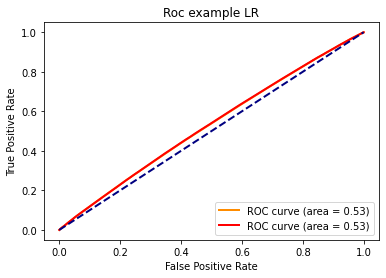

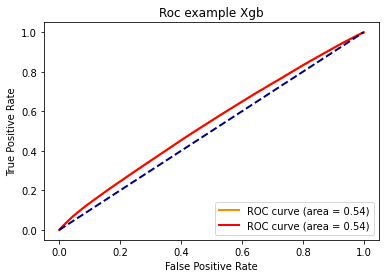

In [ ]:
def draw_roc_curve(train_pre_proba, test_pre_proba, train_auc, test_auc, model_name):
    fpr, tpr, roc_auc = train_pre_proba
    test_fpr, test_tpr, test_roc_auc = test_pre_proba

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % train_auc)
    plt.plot(test_fpr, test_tpr, color='red',
             lw=lw, label='ROC curve (area = %0.2f)' % test_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Roc example ' + model_name)
    plt.legend(loc="lower right")
    plt.show()

for name, model in zip(names, models):
    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict_proba(X_test)[:, 1]

    train_roc = roc_curve(y_train, y_train_pred)
    test_roc = roc_curve(y_test, y_test_pred)

    train_auc = roc_auc_score(y_train, y_train_pred)
    test_auc = roc_auc_score(y_test, y_test_pred)

    draw_roc_curve(train_roc, test_roc, train_auc, test_auc, name)

#### set parameter "scale_pos_weight" to deal with the unbalanced dataset: NOT WORKING!

In [ ]:
# ratio of "Not return" class to "Return" class
ratio = float(np.sum(y == 0)) / np.sum(y == 1)
ratio

5.934864661230836

In [ ]:
# Set parameter 'scale_pos_weight' = ratio

param_t1 = {'max_depth': range(3,10,2),
            'min_child_weight': range(1,6,2)
}

model1 = xgb.XGBClassifier(scale_pos_weight=ratio,
            learning_rate=0.02,
            n_estimators=200,
            silent=1,       
            gamma=0,
            max_delta_step=0,
            subsample=0.85,
            colsample_bytree=0.7,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=1,
            seed=0,
            early_stopping_rounds=20, 
            missing=None)


gsearch1 = GridSearchCV(model1, param_t1, verbose=1,    
         cv=TimeSeriesSplit(n_splits=cv).get_n_splits([X_train, y_train]))

gsearch1.fit(X_train, y_train)
best_max_depth, best_min_child_weight = gsearch1.best_params_['max_depth'], gsearch1.best_params_['min_child_weight']


Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [ ]:
print("\nBest score: %0.3f" % gsearch1.best_score_)
print("\nBest parameters set: %s" % gsearch1.best_params_ )


Best score: 0.856

Best parameters set: {'max_depth': 3, 'min_child_weight': 1}


Text(0.5, 0, 'Number of trees')

Text(0, 0.5, 'AUC')

Text(0.5, 1.0, 'XGBoost AUC')

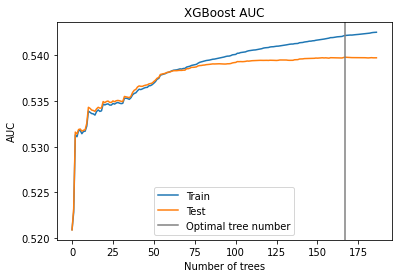

Text(0.5, 0, 'Number of trees')

Text(0, 0.5, 'Classification Logloss')

Text(0.5, 1.0, 'XGBoost Classification Logloss')

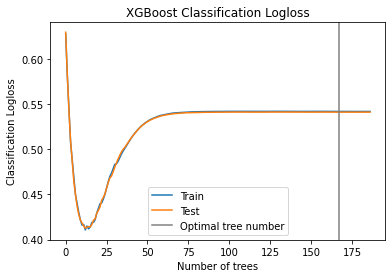

In [ ]:
results = model1.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
plt.axvline(167, color="gray", label="Optimal tree number")
ax.legend()
pyplot.xlabel("Number of trees")
pyplot.ylabel('AUC')
pyplot.title('XGBoost AUC')
pyplot.show()

# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
plt.axvline(167, color="gray", label="Optimal tree number")
ax.legend()
pyplot.xlabel("Number of trees")
pyplot.ylabel('Classification Logloss')
pyplot.title('XGBoost Classification Logloss')
pyplot.show()

'/content/drive/MyDrive/Colab Notebooks/Main Colab Files/CEL/nb_xgb.png'

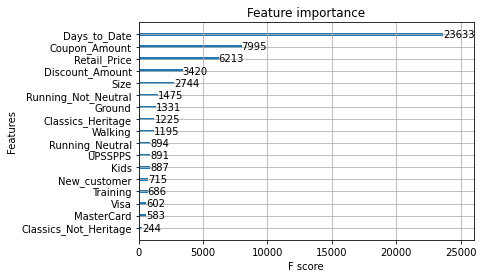

In [ ]:
# 1. Feature Importance Plot
xgb.plot_importance(model)

# 2. no.2 tree
digraph = xgb.to_graphviz(model, num_trees=2)
digraph.format = 'png'
digraph.view('/content/drive/MyDrive/Colab Notebooks/Main Colab Files/CEL/nb_xgb')
